# Benchmarking agents
> This is the second notebook of a series of tutorials to use the [BOUNCE library](https://borjarequena.github.io/BOUNCE/), which we developed for the [Certificates of quantum many-body properties assisted by machine learning](https://arxiv.org/abs/2103.03830) paper.

In the first tutorial, we have seen how to define a problem and optimize its possible relaxations. We also mentioned that we can perform the optimization in different ways. Here, we show how to implement different optimization processes and how to compare them in a consistent way. 

More precisely, we study how the reinforcement learning (RL) optimization compares to a breadth first search (BFS) and a Monte Carlo (MC) optimization.

In [ ]:
#| hide
import numpy as np
from bounce.sdp import SdPEnergySolver
from bounce.environment import SdPEnvironment
from bounce.hamiltonian import XXHamiltonian, Chain1D
from bounce.training import DQNTrainer, BrFSTrainer, MCTrainer
from bounce.utils import state2str, arrange_shape, best_so_far, save_benchmark, load_benchmark

# Comparing different optimizers

## Common problem

In order to compare the optimizers, we need something to optimize! So, the first step is to define a problem. We will continue with the same example of the first tutorial: finding an approximation to the ground state energy of the Heisenberg XX model. 

In [ ]:
# Hamiltonian
N = 6
chain = Chain1D(N)
b, j = 1., [0, 1, 2]
H = XXHamiltonian(chain, b, j)

# Solver
solver = SdPEnergySolver()

# Environment
budget = 305
env = SdPEnvironment(H, solver, budget)

## Evaluation metric towards the goal

Another key element is to find a proper evaluation metric for the agents. In this case, we exploit the clear properties of the system to find the optimal relaxation beforehand. This way, we can evaluate "how close" are the agents to the optimal solution at every step they take.

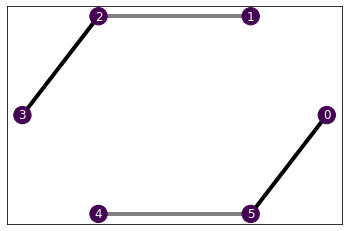

In [ ]:
H.draw()

As we had found in the first tutorial, the optimal relaxation provides a bound of -10.944 with 127 free SdP parameters. In this case, we can obtain the same bound investing all our resources, which involves 288 free parameters. These numbers clearly depend on the computational budget. We can provide this information to the trainers and they will compute the reward with respect to these parameters, which will allow us to compare the progress of the different algorithms towards the goal. 

In [ ]:
# Training parameters
episodes = 400
time_steps = 6
opt = (-10.9443, 127) 
best_ref = np.array([*opt, 288])
n_agents, jobs = 5, 5 # Number of agents to train and parallel threads

## Run the different algorithms

Now we're all set and ready to run the different algorithms. We simply need to define the respective trainers for each of them. All the trainers have a similar sintax.

In [ ]:
learning_rate = 5e-3
batch_size = 160
eps_decay = 0.95

dqn = DQNTrainer(env, n_agents=n_agents, n_jobs=jobs, 
                 learning_rate=learning_rate, batch_size=batch_size, 
                 eps_decay=eps_decay)

brfs = BrFSTrainer(env, n_agents=n_agents, n_jobs=jobs)

mc = MCTrainer(env, n_agents=n_agents, n_jobs=jobs)

Train!

In [ ]:
%time dqn_results = dqn.train(episodes, time_steps=time_steps, opt=opt, best_ref=best_ref, ckp=10)

CPU times: user 4.09 s, sys: 233 ms, total: 4.32 s
Wall time: 21.2 s


In [ ]:
max_states = int(0.4*episodes*time_steps)
%time brfs_results = brfs.train(max_states, opt=opt, best_ref=best_ref)

CPU times: user 119 ms, sys: 1.78 ms, total: 121 ms
Wall time: 731 ms


In [ ]:
%time mc_results = mc.train(max_states, opt=opt, best_ref=best_ref)

CPU times: user 89.3 ms, sys: 0 ns, total: 89.3 ms
Wall time: 870 ms


Let's see the results!

In [ ]:
import matplotlib.pyplot as plt

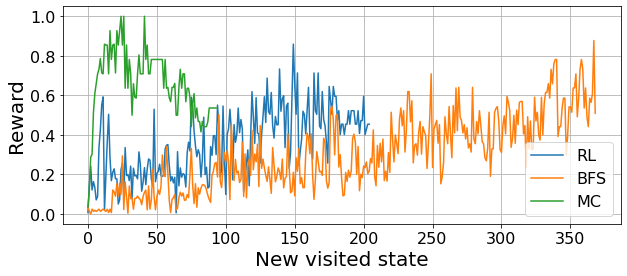

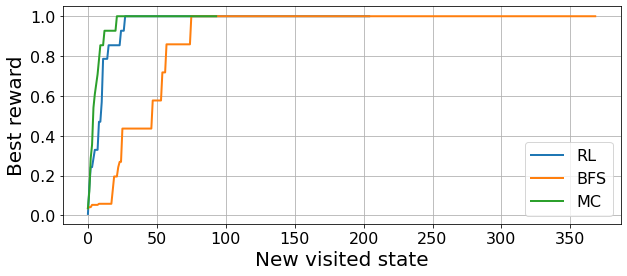

In [ ]:
dqn_expl = dqn_results["exploration"]
dqn_rewards = arrange_shape(dqn_expl['oracle_rewards'])
brfs_rewards = arrange_shape(brfs_results['oracle_rewards'])
mc_rewards = arrange_shape(mc_results['oracle_rewards'])

plt.figure(figsize=(10, 4))
plt.plot(np.mean(dqn_rewards, axis=0), label="RL")
plt.plot(np.mean(brfs_rewards, axis=0), label="BFS")
plt.plot(np.mean(mc_rewards, axis=0), label="MC")
plt.grid()
plt.legend(fontsize=16)
plt.tick_params(labelsize=16)
plt.xlabel("New visited state", fontsize=20)
plt.ylabel("Reward", fontsize=20)


plt.figure(figsize=(10, 4))
plt.plot(np.mean(best_so_far(dqn_rewards), axis=0), linewidth=2, label="RL")
plt.plot(np.mean(best_so_far(brfs_rewards), axis=0), linewidth=2, label="BFS")
plt.plot(np.mean(best_so_far(mc_rewards), axis=0), linewidth=2, label="MC")
plt.grid()
plt.legend(fontsize=16)
plt.tick_params(labelsize=16)
plt.xlabel("New visited state", fontsize=20)
plt.ylabel("Best reward", fontsize=20);

In these plots we see the progress that the different agents do towards the goal. In the first one, we see how close are the agents to the optimal relaxation, on average, with every new step they take. This allows us to see how the different agents explore the constraint-space. For instance, we see a clear collective trend in the BFS exploration, as they all follow a similar exploration strategy.

The second plot provides a clearer idea of the progress towards the goal. In this case, we take the mean over all agents of their best ever reward. Hence, we obtain monotonic lines that show the ensemble progress towards the optimal relaxation: once they reach unit value it means that all agents have found the optimal relaxation. In our work, we use this information to compare the different optimization strategies in multiple scenarios, which we show below.

# Benchmarking for different system sizes

Here, we extend the study that we have shown up until now to several system sizes and budgets. This way, we can see how the different algorithms scale and where they excel or fail the most. 

We consider two budgets: one allowing half of the 3-body constraints and one allowing all the 3-body constraints. 

Execute either of the two cells below to set up the parameters. Beware that the simulations may take quite long and that you may have to adapt the `jobs` parameter (number of parallel threads) such that the task fits into your CPU and GPU. Benchmarks up to $N=14$ take reasonable time. We plot the results in the _04_plots.ipynb_ notebook, with the rest of the paper plots.  

In [ ]:
file_suffix = "half_3"
configs = {5:  {'opt': (-7.4721, 79),   'worst': 132, 'max_limit': 135, 'episodes': 100, 'decay': 0.5, 'jobs': 17},
           6:  {'opt': (-10.9443, 127), 'worst': 180, 'max_limit': 185, 'episodes': 200, 'decay': 0.5, 'jobs': 17},
           7:  {'opt': (-11.9443, 131), 'worst': 192, 'max_limit': 195, 'episodes': 200, 'decay': 0.5, 'jobs': 17},
           8:  {'opt': (-12.9443, 143), 'worst': 240, 'max_limit': 245, 'episodes': 375, 'decay': 0.95, 'jobs': 17},
           9:  {'opt': (-16.4164, 191), 'worst': 252, 'max_limit': 255, 'episodes': 375, 'decay': 0.95, 'jobs': 17},
           10: {'opt': (-17.4164, 195), 'worst': 300, 'max_limit': 305, 'episodes': 375, 'decay': 0.95, 'jobs': 17},
           11: {'opt': (-18.4164, 207), 'worst': 312, 'max_limit': 315, 'episodes': 450, 'decay': 0.95, 'jobs': 17},
           12: {'opt': (-21.8885, 255), 'worst': 360, 'max_limit': 365, 'episodes': 500, 'decay': 0.95, 'jobs': 17},
           13: {'opt': (-22.8885, 259), 'worst': 372, 'max_limit': 375, 'episodes': 500, 'decay': 0.95, 'jobs': 17},
           14: {'opt': (-23.8885, 271), 'worst': 420, 'max_limit': 425, 'episodes': 675, 'decay': 0.95, 'jobs': 17},
           15: {'opt': (-27.3607, 319), 'worst': 432, 'max_limit': 435, 'episodes': 675, 'decay': 0.95, 'jobs': 17},
           16: {'opt': (-28.3607, 323), 'worst': 480, 'max_limit': 485, 'episodes': 700, 'decay': 0.95, 'jobs': 17},
           17: {'opt': (-29.3607, 335), 'worst': 492, 'max_limit': 500, 'episodes': 800, 'decay': 0.98, 'jobs': 17},
           18: {'opt': (-32.8328, 383), 'worst': 540, 'max_limit': 545, 'episodes': 750, 'decay': 0.98, 'jobs': 15},
           19: {'opt': (-33.8328, 383), 'worst': 552, 'max_limit': 555, 'episodes': 750, 'decay': 0.98, 'jobs': 15}
           }
temp = 0.084 # Monte Carlo temperature

In [ ]:
file_suffix = "all_3"
configs = {5:  {'opt': (-7.4721, 79),   'worst': 240, 'max_limit': 245, 'episodes': 100, 'decay': 0.5, 'jobs': 17},
           6:  {'opt': (-10.9443, 127), 'worst': 288, 'max_limit': 300, 'episodes': 200, 'decay': 0.5, 'jobs': 17},
           7:  {'opt': (-11.9443, 131), 'worst': 336, 'max_limit': 340, 'episodes': 200, 'decay': 0.5, 'jobs': 17},
           8:  {'opt': (-12.9443, 143), 'worst': 385, 'max_limit': 385, 'episodes': 400, 'decay': 0.95, 'jobs': 17},
           9:  {'opt': (-16.4164, 191), 'worst': 432, 'max_limit': 435, 'episodes': 400, 'decay': 0.95, 'jobs': 17},
           10: {'opt': (-17.4164, 195), 'worst': 480, 'max_limit': 485, 'episodes': 400, 'decay': 0.95, 'jobs': 17},
           11: {'opt': (-18.4164, 207), 'worst': 528, 'max_limit': 530, 'episodes': 500, 'decay': 0.95, 'jobs': 17},
           12: {'opt': (-21.8885, 255), 'worst': 576, 'max_limit': 580, 'episodes': 600, 'decay': 0.95, 'jobs': 17},
           13: {'opt': (-22.8885, 259), 'worst': 624, 'max_limit': 625, 'episodes': 600, 'decay': 0.95, 'jobs': 17},
           14: {'opt': (-23.8885, 271), 'worst': 672, 'max_limit': 675, 'episodes': 1000, 'decay': 0.95, 'jobs': 17},
           15: {'opt': (-27.3607, 319), 'worst': 720, 'max_limit': 725, 'episodes': 1100, 'decay': 0.95, 'jobs': 17},
           16: {'opt': (-28.3607, 323), 'worst': 768, 'max_limit': 770, 'episodes': 1100, 'decay': 0.95, 'jobs': 17},
           17: {'opt': (-29.3607, 335), 'worst': 816, 'max_limit': 820, 'episodes': 1500, 'decay': 0.98, 'jobs': 17},
           }
temp = 0.097 # Monte Carlo temperature

In [ ]:
Ns = np.arange(5, 17)

n_agents = 60

lr = 5e-3
bm = 20
eps_0 = 0.9

for N in tqdm(Ns):
    N = int(N)
    config = configs[N]
    B, J = 1, [i%3 for i in range(N)]
    H = XXHamiltonian(Chain1D(N), B, J)
    budget = config['max_limit']
    env = SdPEnvironment(H, SdPEnergySolver(), budget)
    
    episodes, eps_decay, n_jobs = config['episodes'], config['decay'], config['jobs']
    opt, worst = config['opt'], config['worst']
    time_steps = int(1.1*N)
    batch_size = time_steps*bm
    best_ref = np.array([*opt, worst])
    max_states = int(episodes*time_steps*0.35) # Maximum number of states allowed for MC and BFS
    
    # Monte Carlo optimization
    mc = MCTrainer(env, n_agents=n_agents, n_jobs=17, beta=temp)
    mc_results = mc.train(max_states, opt=opt, best_ref=best_ref, ckp=5, break_opt=True)
    save_benchmark(mc_results, N, H, 'MC', suffix=file_suffix)
    del mc; del mc_results
    
    # RL optimization
    id0 = 0
    dqn = DQNTrainer(env, n_agents=n_agents, n_jobs=n_jobs, learning_rate=lr, 
                     batch_size=batch_size, eps_decay=eps_decay, eps_0=eps_0)
    dqn_results = dqn.train(episodes, time_steps=time_steps, opt=opt, best_ref=best_ref, ckp=2,
                            id0=id0, break_opt=True, save=False)
    save_benchmark(dqn_results, N, H, 'DQN', suffix=file_suffix)
    del dqn; del dqn_results    
    
    # BFS
    bfs = BrFSTrainer(env, n_agents=n_agents, n_jobs=n_jobs)
    bfs_results = bfs.train(max_states, opt=opt, best_ref=best_ref, break_opt=True)
    save_benchmark(bfs_results, N, H, 'BFS', suffix=file_suffix)
    del bfs; del bfs_results

    # Random walk        
#     rnd = MCTrainer(env, n_agents=n_agents, n_jobs=n_jobs, beta=10000)
#     rnd_results = rnd.train(max_states, opt=opt, best_ref=best_ref, break_opt=True)
#     save_benchmark(rnd_results, N, H, 'RND', suffix=file_suffix)
#     del rnd; del rnd_results